# The vertical Sato-Tate-Distribution



In the following, we take a closer look at the vertical Sato-Tate-Distribution.
Fix a prime $p$. Then take the $a_p$-values of all Elliptic Curves over $\mathbb{F}_p$ and normalize them, i.e. take $\frac{a_p}{2\sqrt{p}}$.
Due to the Hasse-Weil-bound we have $-1 < \frac{a_p}{2\sqrt{p}} < 1$ for all of these values.
As a result, we can view this as a probability distribution:

In [1]:
import sage_src.vertical_st as vertical_st

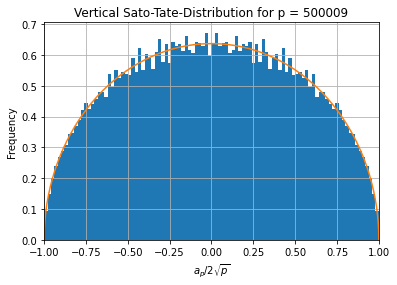

In [2]:
p = 500009
vertical_st.histogram(100, p)

It is proven that for $\lim\limits_{p \to \infty}$ this distribution converges to a semicircle (orange).

In the following, we investigate the speed of convergence.
We define $\Delta$ to be the L2-difference of the vertical Distribution and the semicircle.
It ist computed with the function 
```python
Delta(p, a, b, max_points=300)
```
that depends on the prime $p$ where the vertical distribution is computed and an interval $(a,b)$.  
```max_points``` tells the number of points used for the numerical integration.

We now ask the question how $\Delta$ evolves over time. 
### Conjecture
$$\Delta^2 = \mathcal O(p)$$

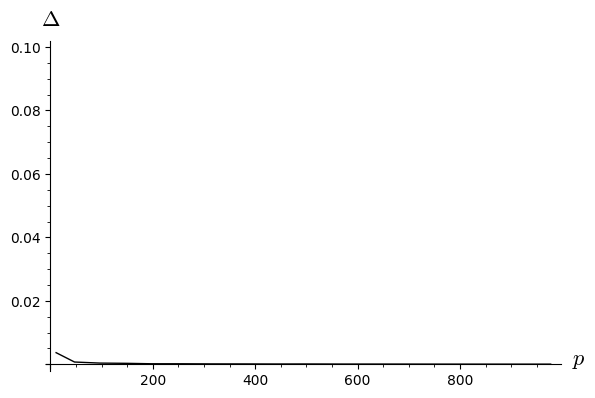

In [3]:
vertical_st.plot_Delta(1000)

Therefore we define $\theta$ by
$$\theta(p) \coloneqq \frac{\log(\Delta^2)}{\log(p)}$$
Our conjecture now is equivalent to $$\lim\limits_{p\to \infty} \theta(p) = 1$$

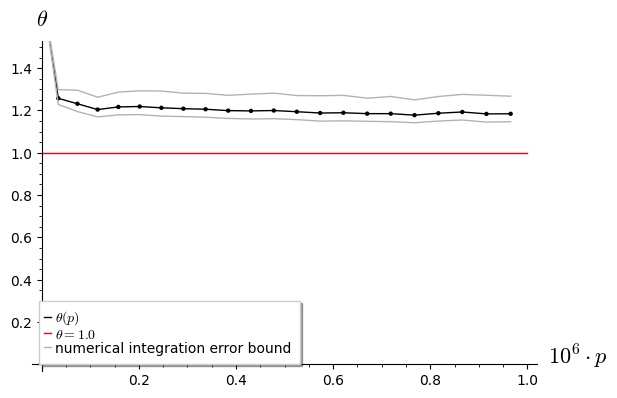

In [4]:
vertical_st.plot_theta(1000000, max_points = 500)

This plot shows that $\theta$ is approaching 1 very slowly, it would as well be possible that
 $\lim_{p \to \infty} \log(\Delta)/\log(p) = 1+\epsilon$, i.e.

$$\Delta = \mathcal O(p^{1+\epsilon})$$
where $\Delta$ is the L2-norm squared and epsilon would be something around 0.2.

In the following, we vary the interval where we analyse the convergence speed and see that $\theta$ gets smaller with smaller interval size. That might just be a statistical effect.

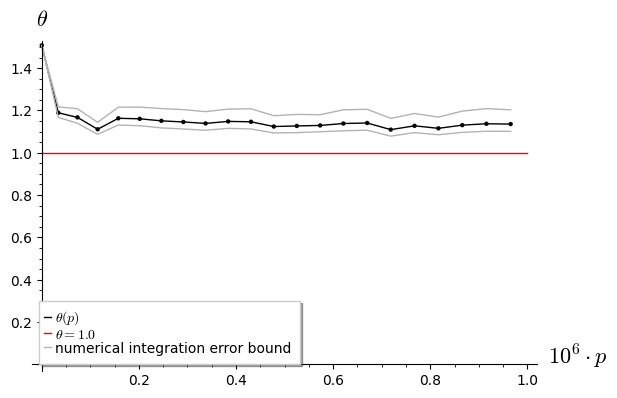

In [5]:
vertical_st.plot_theta(1000000, a=-.5,b=.5, max_points = 500)

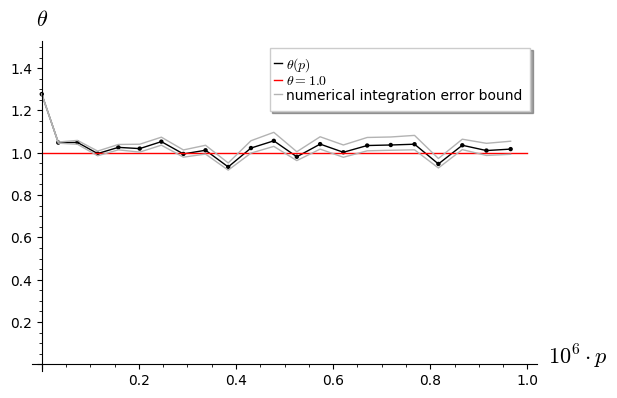

In [6]:
vertical_st.plot_theta(1000000, a=-.1,b=.1, max_points = 300)

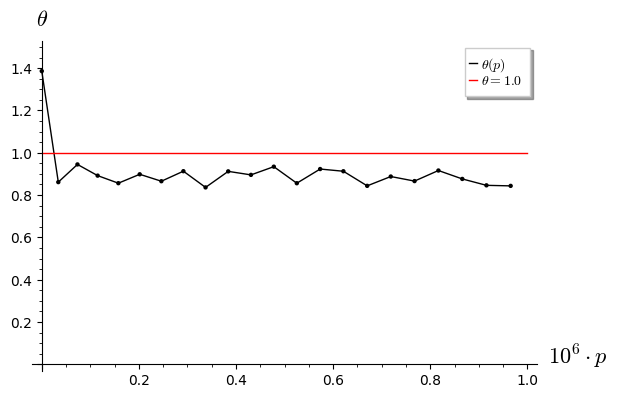

In [7]:
vertical_st.plot_theta(1000000, a=-.01,b=.01, max_points = 100, show_error_bound=False)

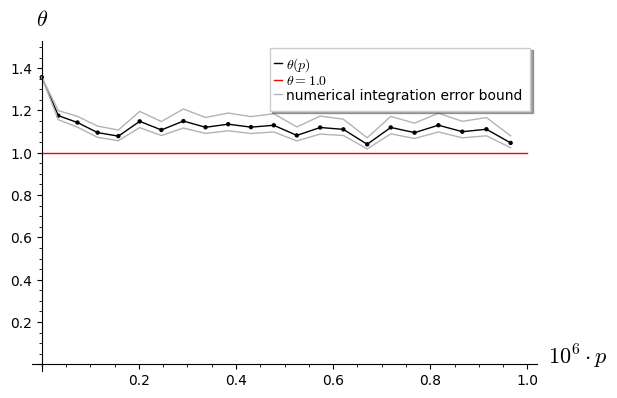

In [8]:
vertical_st.plot_theta(1000000, a=0,b=1, max_points = 500)

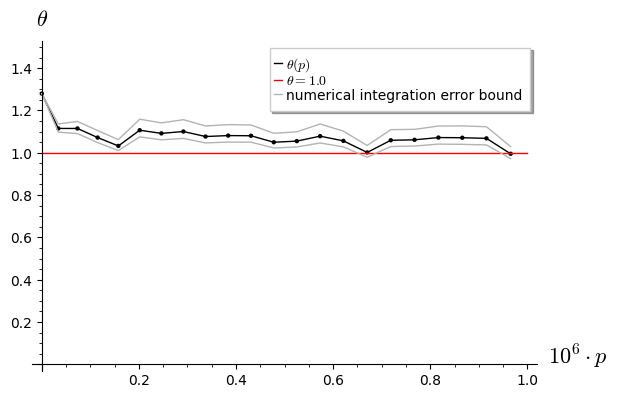

In [9]:
vertical_st.plot_theta(1000000, a=0,b=.5, max_points = 300)

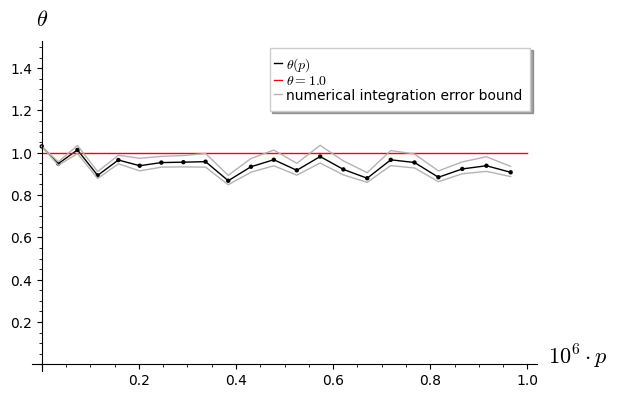

In [10]:
vertical_st.plot_theta(1000000, a=0,b=.1, max_points = 100)

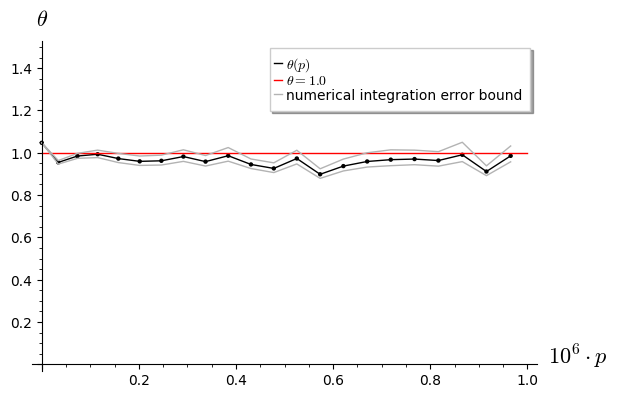

In [11]:
vertical_st.plot_theta(1000000, a=.9,b=1, max_points = 100)